In [55]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

path = r'D:\pic\splits'


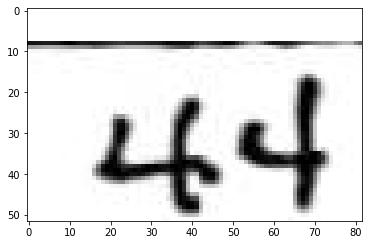

In [56]:
# imraw = plt.imread(os.path.join(path, 'recf.jpg'))

im = Image.open(os.path.join(path, r'10-4.jpg'))

# w, h = im.size
# im.thumbnail((w, 28))
imraw = np.array(im)#[:, :, 0]

plt.imshow(imraw, cmap=plt.cm.gray)
plt.show()


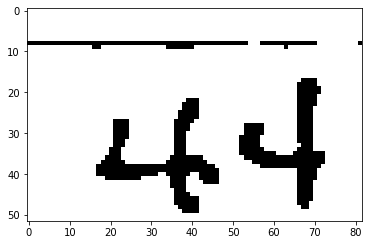

In [57]:
imsolid = np.where(imraw >= 128, 1, 0)
plt.imshow(imsolid, cmap=plt.cm.gray)
plt.show()

In [58]:
hnum = imsolid.shape[0]
vnum = imsolid.shape[1]

vvec = np.mean(imsolid, axis=0)
hvec = np.mean(imsolid, axis=1)


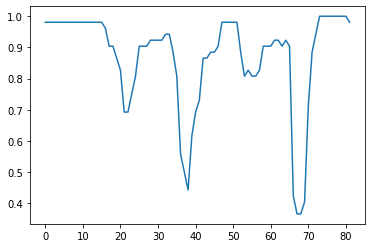

In [59]:
plt.plot(range(vnum),vvec)
plt.show()

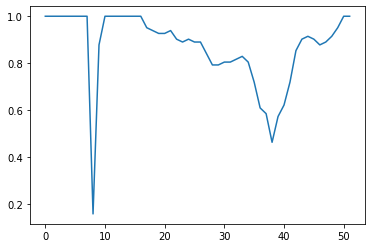

In [60]:
plt.plot(range(hnum),hvec)
plt.show()

In [61]:
vvec_valley = np.where(vvec > 0.9)[0]
vvec_peak = np.where(vvec < max(0.8, np.min(vvec) + 0.1))[0]

print(vvec_valley)
print(vvec_peak)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 25 26 27 28 29
 30 31 32 33 46 47 48 49 50 51 58 59 60 61 62 63 64 65 72 73 74 75 76 77
 78 79 80 81]
[21 22 23 36 37 38 39 40 41 66 67 68 69 70]


In [91]:
valleys = []
valley_start = 0
for i in range(len(vvec_valley)):
    if i - valley_start != vvec_valley[i] - vvec_valley[valley_start]:
        valleys.append(int((vvec_valley[valley_start] + vvec_valley[i - 1]) / 2))
        valley_start = i

valleys.append(int((vvec_valley[valley_start] + vvec_valley[-1]) / 2))

peaks = []
peak_start = 0
for i in range(len(vvec_peak)):
    if i - peak_start != vvec_peak[i] - vvec_peak[peak_start]:
        peaks.append(int((vvec_peak[peak_start] + vvec_peak[i - 1]) / 2))
        peak_start = i

peaks.append(int((vvec_peak[peak_start] + vvec_peak[-1]) / 2))

print(valleys)
print(peaks)

peaks.append(vnum)
valleys = np.array(valleys)
peaks = np.array(peaks)
back = 0
splits = []
for front in peaks:
    choose = np.where((valleys >= back) & (valleys < front))[0]
    if len(choose) == 1:
        splits.append(valleys[choose[0]])
    if len(choose) > 1:
        middle = (front + back) / 2
        mindist = vnum
        bestvalley=-1
        for vl in valleys[choose]:
            curdist = abs(vl - middle)
            if curdist < mindist:
                bestvalley = vl
                mindist = curdist
        splits.append(bestvalley)
    print(choose)
    back = front
splits


[9, 29, 48, 61, 76]
[22, 38, 68]
[0]
[1]
[2 3]
[4]


[9, 29, 48, 76]

In [92]:
n = 3
midarr = splits[1:-1]

sortedval_splits = np.argsort(list((map(lambda x: vvec[x], midarr))))

sortedval_splits = np.where(sortedval_splits < n - 2)[0]

midarr = list(map(lambda x: midarr[x], sortedval_splits))

splits = [splits[0]] + midarr + [splits[-1]]
splits


[9, 29, 76]

5.828130829498819 15.582763337893297
12.219539567472474 16.622008553489643


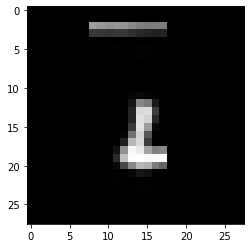

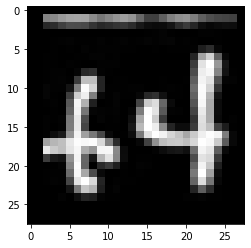

In [93]:
from PIL import ImageOps

splitted_im = []
regsize = 28

for i in range(len(splits) - 1):
    # if splits[i + 1] - splits[i] < hnum / 10:
    #     continue
    curimg = im.crop((splits[i], 0, splits[i + 1], hnum))
    curimg.thumbnail((100, regsize))
    arrayed = np.array(curimg)#[:, :, 0]
    factor = 255 / np.max(arrayed)
    arrayed = 255 - arrayed * factor
    curimg = Image.fromarray(arrayed)
    # curimg.show()

    # 求重心
    curw = arrayed.shape[1]
    sumxw = 0
    sumyw = 0
    sumw = 0
    for i in range(regsize):
        for j in range(curw):
            sumxw += j * arrayed[i][j]
            sumyw += i * arrayed[i][j]
            sumw += arrayed[i][j]
    xcenter = sumxw / sumw
    ycenter = sumyw / sumw
    print(xcenter, ycenter)
    # leftpadding = int((regsize - curw) / 2)
    # rightpadding = regsize - curw - leftpadding
    padcurimg = curimg.crop((xcenter - regsize / 2, 
                             ycenter - regsize / 2, 
                             xcenter + regsize / 2, 
                             ycenter + regsize / 2))
    
    splitted_im.append(np.array(padcurimg))

for img in splitted_im:
    plt.imshow(img, cmap=plt.cm.gray)
    plt.show()


In [72]:
netimages = []
for img in splitted_im:
    netimages.append(img.flatten())
netimages = np.array(netimages)
# print(netimages[1])

In [73]:
import tensorflow as tf

sess = tf.Session()

model_file = tf.train.latest_checkpoint(r'D:\pic\net2')
saver = tf.train.import_meta_graph(model_file + '.meta')

saver.restore(sess, model_file)
graph = tf.get_default_graph()

# for op in graph.get_operations():
#     print(op.name)

x = graph.get_tensor_by_name("x:0")
y = graph.get_tensor_by_name("y:0")
keep = graph.get_tensor_by_name("keep:0")


INFO:tensorflow:Restoring parameters from D:\pic\net2\predictmodel.ckpt-19999


In [74]:
result_test = sess.run(y, feed_dict={x: netimages, keep: 0.5})
np.argmax(result_test,axis=1)

array([2, 6, 4], dtype=int64)

In [69]:
result_test

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)